# MMD test on all datasets 

In this notebook, we do the MMD test on all the dataset we have trained a NN on. 

We have : $$ \begin{eqnarray}
                X_1,...,X_n &\sim \mathcal{D}_{\text{NN}} \\
                Y_1,...,Y_n &\sim \mathcal{D}_{\text{Gudhi}}\end{eqnarray}
            $$
            

 and we want to test $$ H_0 : \mathcal{D}_{\text{NN}} = \mathcal{D}_{\text{Gudhi}}$$
    We use a gaussian kernel : $k(X_i,Y_j) = \exp{\left(-\frac{\Vert X_i - Y_j\Vert^2}{2\sigma^2}\right)}$ where Gretton *et al*. recommend to set the parameter $\sigma$ to be the median distance between points in the aggregated sample and we compute $\widehat{MMD}$ :
     $$\widehat{MMD} = \frac{1}{n^2}\sum\limits_{i,j = 1}^n k(X_i,X_j) + \frac{1}{n^2}\sum\limits_{i,j = 1}^n k(Y_i,Y_j) - \frac{2}{n^2}\sum\limits_{i,j = 1}^n k(X_i,Y_j) $$
    We compute the p-value with a permutation test.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from IPython.display import SVG

import gudhi as gd
import gudhi.representations

from scipy.spatial.distance import pdist

from tqdm import tqdm
from multiple_circle import create_random_circle

2021-07-23 17:25:36.867224: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


This is the fonction that computes the MMD statistic given two samples and a $\sigma$

In [2]:
def compute_mmd(X, Y, sigma):
    xx = np.matmul(X, X.transpose())
    yy = np.matmul(Y, Y.transpose())
    xy = np.matmul(X, Y.transpose())

    rx = np.broadcast_to(np.expand_dims(np.diag(xx), 0), xx.shape)
    ry = np.broadcast_to(np.expand_dims(np.diag(yy), 0), yy.shape)

    dxx = rx.transpose() + rx - 2. * xx
    dyy = ry.transpose() + rx - 2. * yy
    dxy = rx.transpose() + ry - 2. * xy
    #print(np.max(xx),np.max(xy),np.max(yy))
    XX = np.exp(dxx / (-2 * sigma**2))
    YY = np.exp(dyy / (-2 * sigma**2))
    XY = np.exp(dxy / (-2 * sigma**2))

    return (XX + YY - 2. * XY).mean()

This fonction computes the p-value of the MMD test using a permutation test.

In [3]:
def compute_pvalue(X, Y, n_permut):
    sigma = np.median(pdist(np.concatenate((X, Y)))) / 2

    our_mmd = compute_mmd(X, Y, sigma)
    both_distrib = np.concatenate((X, Y))

    print("True MMD = ", our_mmd)
    mmds = []
    for i in tqdm(range(n_permut)):
        xy = np.random.permutation(both_distrib)
        mmds.append(compute_mmd(xy[X.shape[0]:], xy[:X.shape[0]], sigma))
    mmds = np.array(mmds)
    plt.hist(mmds, bins=20)
    return (our_mmd < mmds).mean()

---

## For the dynamical system 

We compute some new orbites, thier true peristence images and thier predicted one and then we do the MMD test.

In [ ]:
model_PI = tf.keras.models.load_model(
    'Saved_Model/model_1_alpha_complex_normalized/')
model_PI.summary()

In [139]:
N_sets = 100
N_points = 500
PI_size = 50

In [140]:
def create_orbit(N_points, r):
    X = np.empty([N_points, 2])
    x, y = np.random.uniform(), np.random.uniform()
    for i in range(N_points):
        X[i, :] = [x, y]
        x = (X[i, 0] + r * X[i, 1] * (1 - X[i, 1])) % 1.
        y = (X[i, 1] + r * x * (1 - x)) % 1.

    return X

In [141]:
data_sets = np.zeros((N_sets, N_points, 2))

r_list = [3.4, 4.1]

for i in tqdm(range(N_sets), desc='Generating dataset : '):
    #Generate the orbit
    r = np.random.choice(r_list)
    data_sets[i] = create_orbit(N_points, r)

Generating dataset : 100%|██████████| 100/100 [00:00<00:00, 522.22it/s]


In [143]:
PI_gudhi = np.zeros((N_sets, PI_size * PI_size))

for i in range(N_sets):
    rcX = gd.AlphaComplex(points=data_sets[i]).create_simplex_tree()
    dgmX = rcX.persistence()

    PI = gd.representations.PersistenceImage(bandwidth=5e-3,
                                             weight=lambda x: x[1]**2,
                                             resolution=[50, 50],
                                             im_range=[0, 0.03, 0, 0.03])
    pi = PI.fit_transform([rcX.persistence_intervals_in_dimension(1)])
    PI_gudhi[i] = pi[0]
PI_gudhi /= np.max(PI_gudhi)

In [144]:
PI_NN = model_PI.predict(data_sets)

  2%|▏         | 16/1000 [00:00<00:06, 154.95it/s]

True MMD =  0.14030701725614292


100%|██████████| 1000/1000 [00:06<00:00, 151.95it/s]


1.0

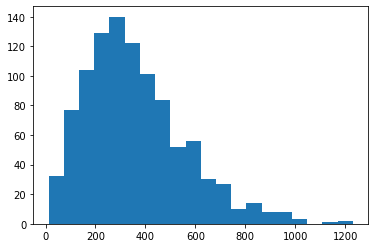

In [147]:
compute_pvalue(PI_NN, PI_gudhi, 1000)

The MMD est 1.

---

## For the multiple circles dataset 

In [14]:
model_PI = tf.keras.models.load_model('Saved_Model/model_2_multiple_cricles/')
model_PI.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 600, 2)]          0         
_________________________________________________________________
fully_connected2 (FullyConne (None, 600, 30)           60        
_________________________________________________________________
tf.nn.relu (TFOpLambda)      (None, 600, 30)           0         
_________________________________________________________________
dense (Dense)                (None, 600, 20)           620       
_________________________________________________________________
dense_1 (Dense)              (None, 600, 10)           210       
_________________________________________________________________
lambda (Lambda)              (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                550   

In [15]:
N_sets = 100
N_points = 600
PI_size = 50

In [24]:
data_sets = np.zeros((N_sets, N_points, 2))

for i in tqdm(range(N_sets), desc='Generating dataset : '):
    data_sets[i] = create_random_circle(N_points)

Generating dataset : 100%|██████████| 100/100 [00:00<00:00, 271.77it/s]


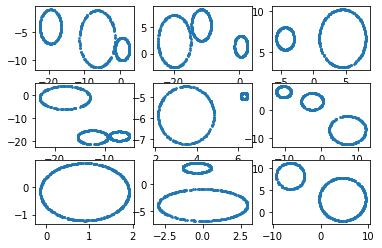

In [17]:
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.scatter(data_sets[i, :, 0], data_sets[i, :, 1], s=3)

In [18]:
PI_NN = model_PI.predict(data_sets)

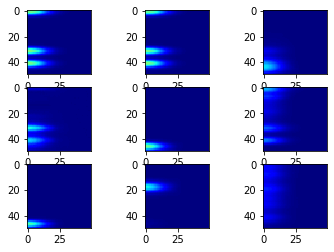

In [19]:
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(np.flip(np.reshape(PI_NN[i], [PI_size, PI_size]), 0),
               vmin=0,
               vmax=1,
               cmap='jet')

In [20]:
PI_gudhi = np.zeros((N_sets, PI_size * PI_size))

for i in range(N_sets):
    rcX = gd.AlphaComplex(points=data_sets[i]).create_simplex_tree()
    dgmX = rcX.persistence()

    PI = gd.representations.PersistenceImage(
        bandwidth=1,
        weight=lambda x: 10 * np.tanh(x[1]),
        resolution=[PI_size, PI_size],
        im_range=[0, 5, 0, 25])
    pi = PI.fit_transform([rcX.persistence_intervals_in_dimension(1)])
    PI_gudhi[i] = pi[0]
PI_gudhi /= np.max(PI_gudhi)

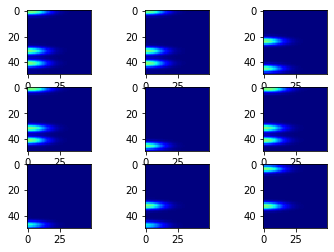

In [21]:
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(np.flip(
        np.reshape(PI_gudhi[i] / np.max(PI_gudhi), [PI_size, PI_size]), 0),
               vmin=0,
               vmax=1,
               cmap='jet')

In [22]:
(np.square(PI_NN - PI_gudhi)).mean(axis=None)

0.001601593231838284

  1%|▏         | 13/1000 [00:00<00:07, 125.77it/s]

True MMD =  0.29095165600529793


100%|██████████| 1000/1000 [00:07<00:00, 138.24it/s]


1.0

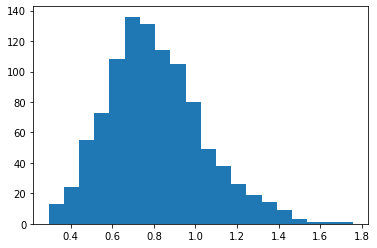

In [23]:
compute_pvalue(PI_NN, PI_gudhi, 1000)

## Only one circle

In [4]:
model_PI = tf.keras.models.load_model('Saved_Model/model_smaller_cricles/')

2021-07-23 17:26:18.858661: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-07-23 17:26:19.084320: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-07-23 17:26:19.084876: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 960M computeCapability: 5.0
coreClock: 1.176GHz coreCount: 5 deviceMemorySize: 1.96GiB deviceMemoryBandwidth: 74.65GiB/s
2021-07-23 17:26:19.084900: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-07-23 17:26:19.085101: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No suc

In [5]:
N_sets = 100
N_points = 500
PI_size = 50

In [6]:
def create_circle(N_points, r, x_0, y_0):
    X = []
    for i in range(N_points): #On fait un cercle
        theta = np.random.uniform()*2*np.pi
        X.append([(r*np.cos(theta))+x_0,(r*np.sin(theta)+y_0)])
    return np.array(X)

In [14]:
data_sets = np.zeros((N_sets, N_points, 2))

for i in tqdm(range(N_sets), desc='Generating dataset : '):
    r = np.random.random()
    data_sets[i] = create_circle(N_points,r,0,0)

Generating dataset : 100%|███████████████████| 100/100 [00:00<00:00, 347.22it/s]


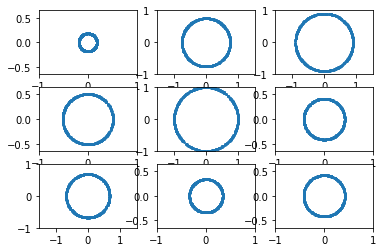

In [15]:
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.scatter(data_sets[i, :, 0], data_sets[i, :, 1], s=3)
    plt.axis("equal")
    plt.xlim(-1,1)
    plt.ylim(-1,1)

In [16]:
PI_NN = model_PI.predict(data_sets)

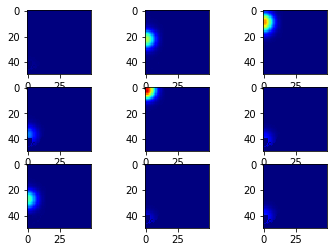

In [17]:
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(np.flip(np.reshape(PI_NN[i], [PI_size, PI_size]), 0),
               vmin=0,
               vmax=1,
               cmap='jet')

In [18]:
PI_gudhi = np.zeros((N_sets, PI_size * PI_size))

PI = gd.representations.PersistenceImage(bandwidth=1e-1,
                                             weight=lambda x: x[1]**(1),
                                             resolution=[PI_size, PI_size], im_range=[0, 1, 0, 1])
for i in range(N_sets):
    rcX = gd.AlphaComplex(points=data_sets[i]).create_simplex_tree()
    dgmX = rcX.persistence()

    pi = PI.fit_transform([rcX.persistence_intervals_in_dimension(1)])
    PI_gudhi[i] = pi[0]
PI_gudhi /= np.max(PI_gudhi)

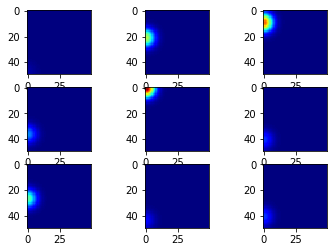

In [19]:
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(np.flip(
        np.reshape(PI_gudhi[i] / np.max(PI_gudhi), [PI_size, PI_size]), 0),
               vmin=0,
               vmax=1,
               cmap='jet')

  2%|▋                                       | 17/1000 [00:00<00:06, 163.73it/s]

True MMD =  0.043212095574657876


100%|██████████████████████████████████████| 1000/1000 [00:05<00:00, 168.91it/s]


1.0

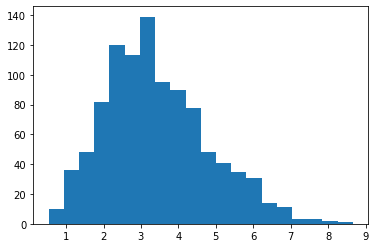

In [20]:
compute_pvalue(PI_NN, PI_gudhi, 1000)

## Whitney embedding 

In [24]:
model_PI = tf.keras.models.load_model(
    'Saved_Model/model_withney_embedding_dynamical_syst/')

In [19]:
def create_orbit(N_points, r):
    X = np.empty([N_points, 2])
    x, y = np.random.uniform(), np.random.uniform()
    for i in range(N_points):
        X[i, :] = [x, y]
        x = (X[i, 0] + r * X[i, 1] * (1 - X[i, 1])) % 1.
        y = (X[i, 1] + r * x * (1 - x)) % 1.

    return X

In [27]:
N_sets = 100
N_points = 500
data_sets = np.zeros((N_sets, N_points, 2))

r_list = [3.4, 4.1]

for i in tqdm(range(N_sets), desc='Generating dataset : '):
    #Generate the orbit
    r = np.random.choice(r_list)
    data_sets[i] = create_orbit(N_points, r)

Generating dataset : 100%|██████████| 100/100 [00:00<00:00, 521.17it/s]


In [28]:
def embedding_withney(data):
    new_data = np.zeros((data.shape[0],data.shape[1],4))
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            u = (1 + data[i,j,0]**2)*(1 + data[i,j,1]**2)
            new_data[i,j,0] = 1/u
            new_data[i,j,1] = data[i,j,0] - 2*data[i,j,0]/u
            new_data[i,j,2] = data[i,j,0]*data[i,j,1]/u
            new_data[i,j,3] = data[i,j,1]
    return new_data
        

In [29]:
PI_NN = model_PI.predict(embedding_withney(data_sets))


In [33]:
PI_gudhi = np.zeros((N_sets, 50 * 50))

for i in range(N_sets):
    rcX = gd.AlphaComplex(points=data_sets[i]).create_simplex_tree()
    dgmX = rcX.persistence()

    PI = gd.representations.PersistenceImage(bandwidth=5e-3,
                                             weight=lambda x: x[1]**2,
                                             resolution=[50, 50],
                                             im_range=[0, 0.03, 0, 0.03])
    pi = PI.fit_transform([rcX.persistence_intervals_in_dimension(1)])
    PI_gudhi[i] = pi[0]
PI_gudhi /= np.max(PI_gudhi)

  1%|▏         | 13/1000 [00:00<00:07, 125.81it/s]

True MMD =  68.23174954292553


100%|██████████| 1000/1000 [00:06<00:00, 147.57it/s]


0.998

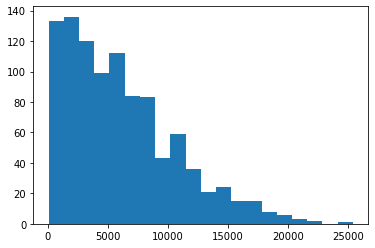

In [37]:
compute_pvalue(PI_NN,PI_gudhi,1000)

## Only one noisy circle

In [43]:
model_PI = tf.keras.models.load_model(
    'Saved_Model/model_noisy_cricles/')

In [44]:
def create_noisy_circle(N_points, r, x_0, y_0,eps):
    X = []
    for i in range(N_points): #On fait un cercle
        theta = np.random.uniform()*2*np.pi
        x = r*np.cos(theta)+x_0 + eps*(np.random.random() - 1/2)
        y = r*np.sin(theta)+y_0 + eps*(np.random.random() - 1/2)
        X.append([x,y])
    return np.array(X)

In [48]:
N_sets = 100
N_points = 500

circles = np.zeros((N_sets, N_points, 2))
for i in range(N_sets):
    eps = 0.5*np.random.random()
    r = np.random.random()
    circles[i] = create_noisy_circle(N_points,r,0,0,eps)

In [49]:
PI_noisy_NN = model_PI.predict(circles)
PI_size = int(np.sqrt(PI_noisy_NN.shape[1]))

In [52]:
PI_gudhi = np.zeros((N_sets, PI_size * PI_size))

for i in range(N_sets):
    rcX = gd.AlphaComplex(points=circles[i]).create_simplex_tree()
    dgmX = rcX.persistence()

    PI = gd.representations.PersistenceImage(bandwidth=1e-1,
                                             weight=lambda x: x[1]**(1),
                                             resolution=[PI_size, PI_size], im_range=[0, 1, 0, 1])
    pi = PI.fit_transform([rcX.persistence_intervals_in_dimension(1)])
    PI_gudhi[i] = pi[0]
PI_gudhi/=np.max(PI_gudhi)

  2%|▏         | 16/1000 [00:00<00:06, 159.20it/s]

True MMD =  17774.651594095674


100%|██████████| 1000/1000 [00:06<00:00, 159.50it/s]


0.512

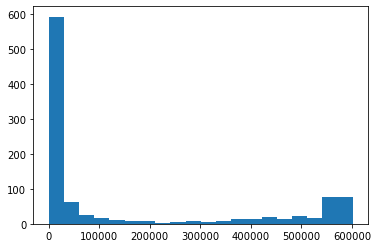

In [54]:
compute_pvalue(PI_noisy_NN,PI_gudhi,1000)

#### Test de KS

In [29]:
from scipy.stats import ks_2samp

In [56]:
p_value_ks = np.zeros(PI_NN[0].shape)
for i in range(len(p_value_ks)):
    p_value_ks[i] = ks_2samp(PI_noisy_NN[:, i], PI_gudhi[:, i])[0]

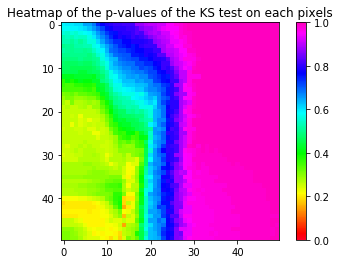

In [58]:
plt.imshow(np.flip(np.reshape(p_value_ks, [PI_size, PI_size]), 0),
           vmin=0,
           vmax=1,
           cmap='gist_rainbow')
plt.colorbar()
plt.title("Heatmap of the p-values of the KS test on each pixels")
plt.savefig("Résultats/Résultats 4/heatmap_p_value_test_one_noisy_circle.pdf")

## Multiple noisy circles

In [4]:
model_PI = tf.keras.models.load_model(
    'Saved_Model/model_multiple_noisy_cricles2/')

In [5]:
from multiple_noisy_circle import create_random_circle

In [6]:
data = np.load('data/PI_data_multiple_noisy_circle_classif.npz')

data_train_classif = data["data_train"]
PI_train_gudhi = data["PI_train"]
PI_test_gudhi = data["PI_test"]
data_test_classif = data["data_test"]

In [7]:
PI_NN = model_PI.predict(data_train_classif)

In [8]:
PI_train_gudhi/=np.max(PI_train_gudhi)

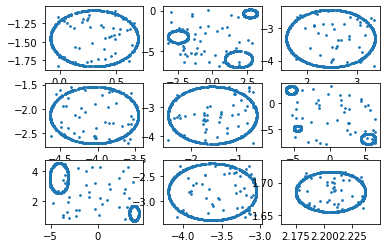

In [9]:
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.scatter(data_train_classif[i, :, 0], data_train_classif[i, :, 1], s=3)
plt.savefig("Résultats/Résultats 4/multiple_noisy_circles_9.pdf")

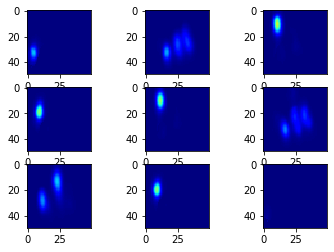

In [10]:
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(np.flip(
        np.reshape(PI_NN[i], [50, 50]), 0),
               vmin=0,
               vmax=1,
               cmap='jet')
plt.savefig("Résultats/Résultats 4/multiple_noisy_circles_predicted.pdf")

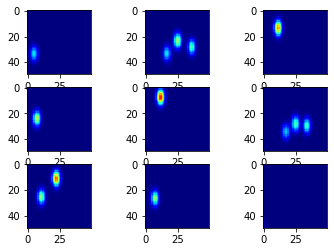

In [11]:
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(np.flip(
        np.reshape(PI_train_gudhi[i], [50, 50]), 0),
               vmin=0,
               vmax=1,
               cmap='jet')
plt.savefig("Résultats/Résultats 4/multiple_noisy_circles_true.pdf")

  2%|▏         | 21/1000 [00:00<00:04, 206.83it/s]

True MMD =  0.019739014809436753


100%|██████████| 1000/1000 [00:04<00:00, 200.10it/s]


1.0

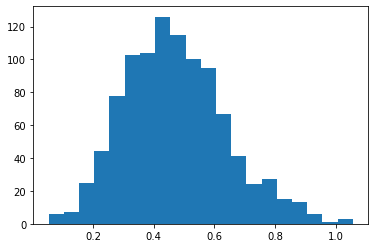

In [14]:
compute_pvalue(PI_NN[:100],PI_train_gudhi[:100]/np.max(PI_test_gudhi),1000)

In [35]:
p_value_ks = np.zeros(PI_NN[0].shape)
for i in range(len(p_value_ks)):
    p_value_ks[i] = ks_2samp(PI_NN[:, i], PI_train_gudhi[:, i])[0]
np.min(p_value_ks)

0.1061061061061061

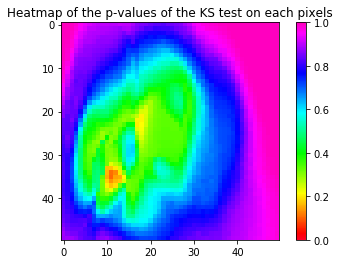

In [36]:
plt.imshow(np.flip(np.reshape(p_value_ks, [50, 50]), 0),
           vmin=0,
           vmax=1,
           cmap='gist_rainbow')
plt.colorbar()
plt.title("Heatmap of the p-values of the KS test on each pixels")
plt.savefig("Résultats/Résultats 4/heatmap_p_value_test_multiple_noisy_circle.pdf")

# MMD for LS

### Dynamical Systems

In [4]:
model_LS = tf.keras.models.load_model(
    'Saved_Model/model_LS_dynamical_system/')

In [5]:
data = np.load('data/LS_data_1000_dynamical_alpha_classif.npz')

#data = np.load('PI_data_1000_dynamical_alpha.npz')
data_train = data["data_train"]
r_train_gudhi = data["r_train"]
LS_train_gudhi = data["LS_train"]
data_test
r_test_gudhi = data["r_test"]
LS_test_gudhi = data["LS_test"]

In [6]:
N_sets_train = LS_train_gudhi.shape[0]
N_sets_test = LS_test_gudhi.shape[0]
LS_res = int(len(LS_train_gudhi[0])/5)
N_points = 500

In [7]:
print("N_sets_train : ", N_sets_train)
print("N_sets_test : ", N_sets_test)
print("LS_res : ", LS_res)

N_sets_train :  2000
N_sets_test :  200
LS_res :  500


In [8]:
LS_train_gudhi /= np.max(LS_train_gudhi)
LS_test_gudhi /= np.max(LS_test_gudhi)

In [9]:
LS_NN = model_LS.predict(data_train)

  1%|          | 11/1000 [00:00<00:09, 107.66it/s]

True MMD =  109.17020558802695


100%|██████████| 1000/1000 [00:06<00:00, 157.58it/s]


0.998

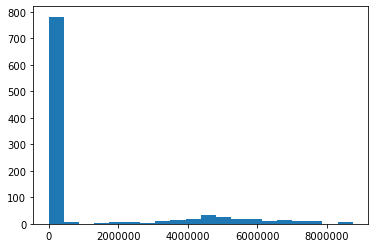

In [10]:
compute_pvalue(LS_NN[:100],LS_train_gudhi[:100],1000)

## Multiple circles

In [12]:
model_LS = tf.keras.models.load_model('Saved_Model/model_LS_multiple_circles/')


In [21]:
data = np.load('data/PI_data_multiple_circle_LS_classif.npz')

#data = np.load('PI_data_1000_dynamical_alpha.npz')
data_train = data["data_train"]
label_train_gudhi = data["label_train"]
LS_train_gudhi = data["PI_train"]
label_test_gudhi = data["label_test"]
LS_test_gudhi = data["PI_test"]

In [22]:
N_sets_train = LS_train_gudhi.shape[0]
N_sets_test = LS_test_gudhi.shape[0]
LS_res = int(len(LS_train_gudhi[0])/5)
N_points = 600

In [23]:
print("N_sets_train : ", N_sets_train)
print("N_sets_test : ", N_sets_test)
print("LS_res : ", LS_res)

N_sets_train :  1998
N_sets_test :  198
LS_res :  800


In [24]:
LS_train_gudhi /= np.max(LS_train_gudhi)
LS_test_gudhi /= np.max(LS_test_gudhi)

In [25]:
LS_NN = model_LS.predict(data_train)

  1%|▏         | 14/1000 [00:00<00:08, 122.35it/s]

True MMD =  0.3766877740425671


100%|██████████| 1000/1000 [00:09<00:00, 105.93it/s]


1.0

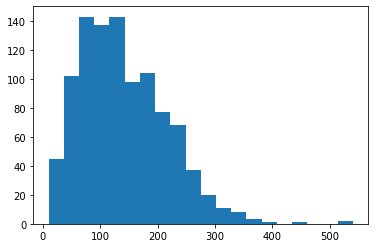

In [26]:
compute_pvalue(LS_NN[:100],LS_train_gudhi[:100],1000)